# Contents

1. Nea. ancestry trajectories for different genomic regions (simulated individually)
2. Desert size vs amount of deleterious sequence (different genomic regions)

In [1]:
suppressPackageStartupMessages({
    library(VariantAnnotation)
    library(rtracklayer)
    library(tidyverse)
    library(ggbeeswarm)
    library(purrr)
})

## 1. Nea. ancestry trajectories for different genomic regions (simulated individually)

I did this mostly to:

* check that the reorganization of my simulation code didn't break things
* test what is the effect of varying the total amount of potentially deleterious sequence on the trajectories (by simulating exons, protein coding regions, promoters, 3' UTRs, etc in isolation)

Shown is the case of additivity ($h = 0.5$) with the mutation rate $=1e-8$ per bp per generation. This is slightly higher than what Kelley and I simulated previously (which was $7e-9$, roughly the mutation rate of non-synonymous mutations). Again, the Nea. ancestry trajectory is the avg Nea. ancestry in all individuals in the population, calculated on ~50k neutral markers distributed throughout the genome (positions sampled from the 500k sites from the admixture array).

Clearly the larger proportion of deleterious sequence, the higher the impact of the Neanderthal genetic load.

**Kelly simulated ~70Mb of exonic sequence and found that one needs ~10% admixture rate so that ~2-3% of Nea. ancestry survives** over time. 

However, we found using logistic regression analysis and analysis of distributions of Nea. ancestry that not only protein coding regions, but also promoters and other non-coding sequence shows signs of negative selection against Nea. ancestry. **In fact, there is more than 200Mb sequence that seems to be under negative selection** against Nea. ancestry (compared to just 70 Mb considered by Kelley).

**If all of that sequence behaves additively or near-dominantly, Neanderthal ancestry would be completely wiped out by negative selection.**

Maybe this is another evidence for recessivity of some of those regions? At least in case of protein coding + TF binding sequence? This would make different regions "compete" - recessive sequence would be selected from Neanderthals, additive/dominant sequence would be selected against. **Maybe the 2% we see today is the result of tug of war between additive and recessive selection?** We _do_ see some evidence that at least TF binding regions behaved recessively.

I saw in my earlier simulations that a mixture of dominances leads to an equilibrium state between dominant and recessive extremes, depending on the ratio between $h=0.0$ and $h=1.0$. Maybe this is what actually happened genome-wide?

In [2]:
h_coeffs <- c("0.0", "0.5", "1.0")

In [3]:
df_h <- lapply(c("exon", "promoter", "protein_coding", "tf_binding_site", "utr3"), function(r) {
lapply(h_coeffs, function(h) {
    files <- list.files(path="../data/simulations/", pattern=paste0(r, "_h_", h, "_rep_.*trajectory.*"), full.names=TRUE)
    lapply(files, function(f) {
        suppressMessages(read_tsv(f) %>% mutate(rep=f, dominance=h, reg=r))
    }) %>% bind_rows
}) %>%
    bind_rows %>% 
    group_by(dominance, gen, reg, rep) %>% summarise(nea_mean=mean(mean), nea_sd=mean(sd)) %>%
    ungroup
}) %>% bind_rows

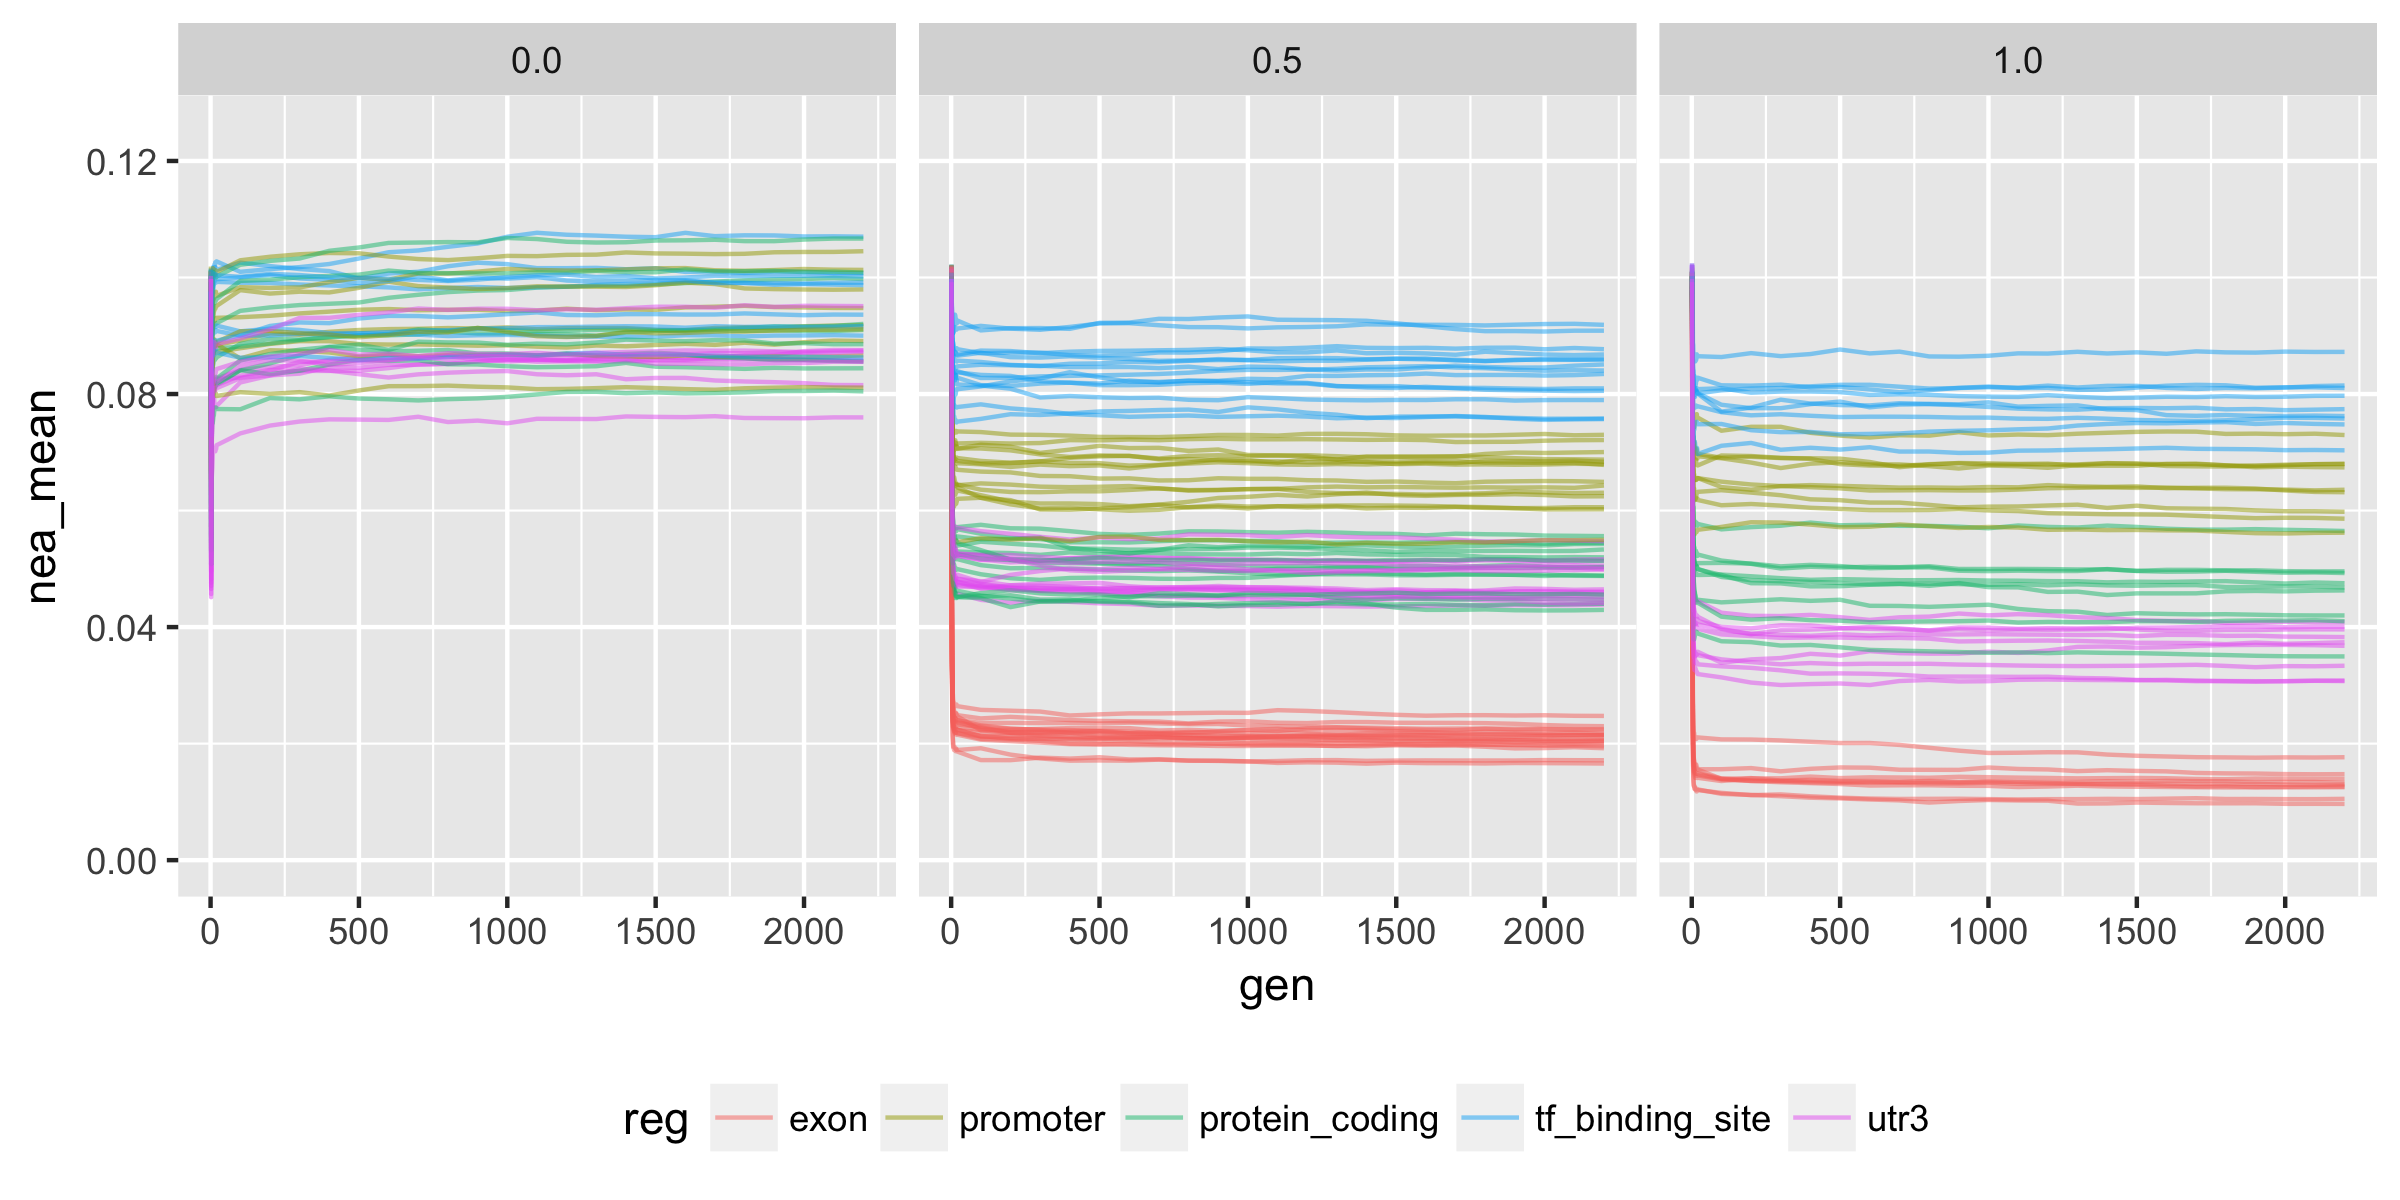

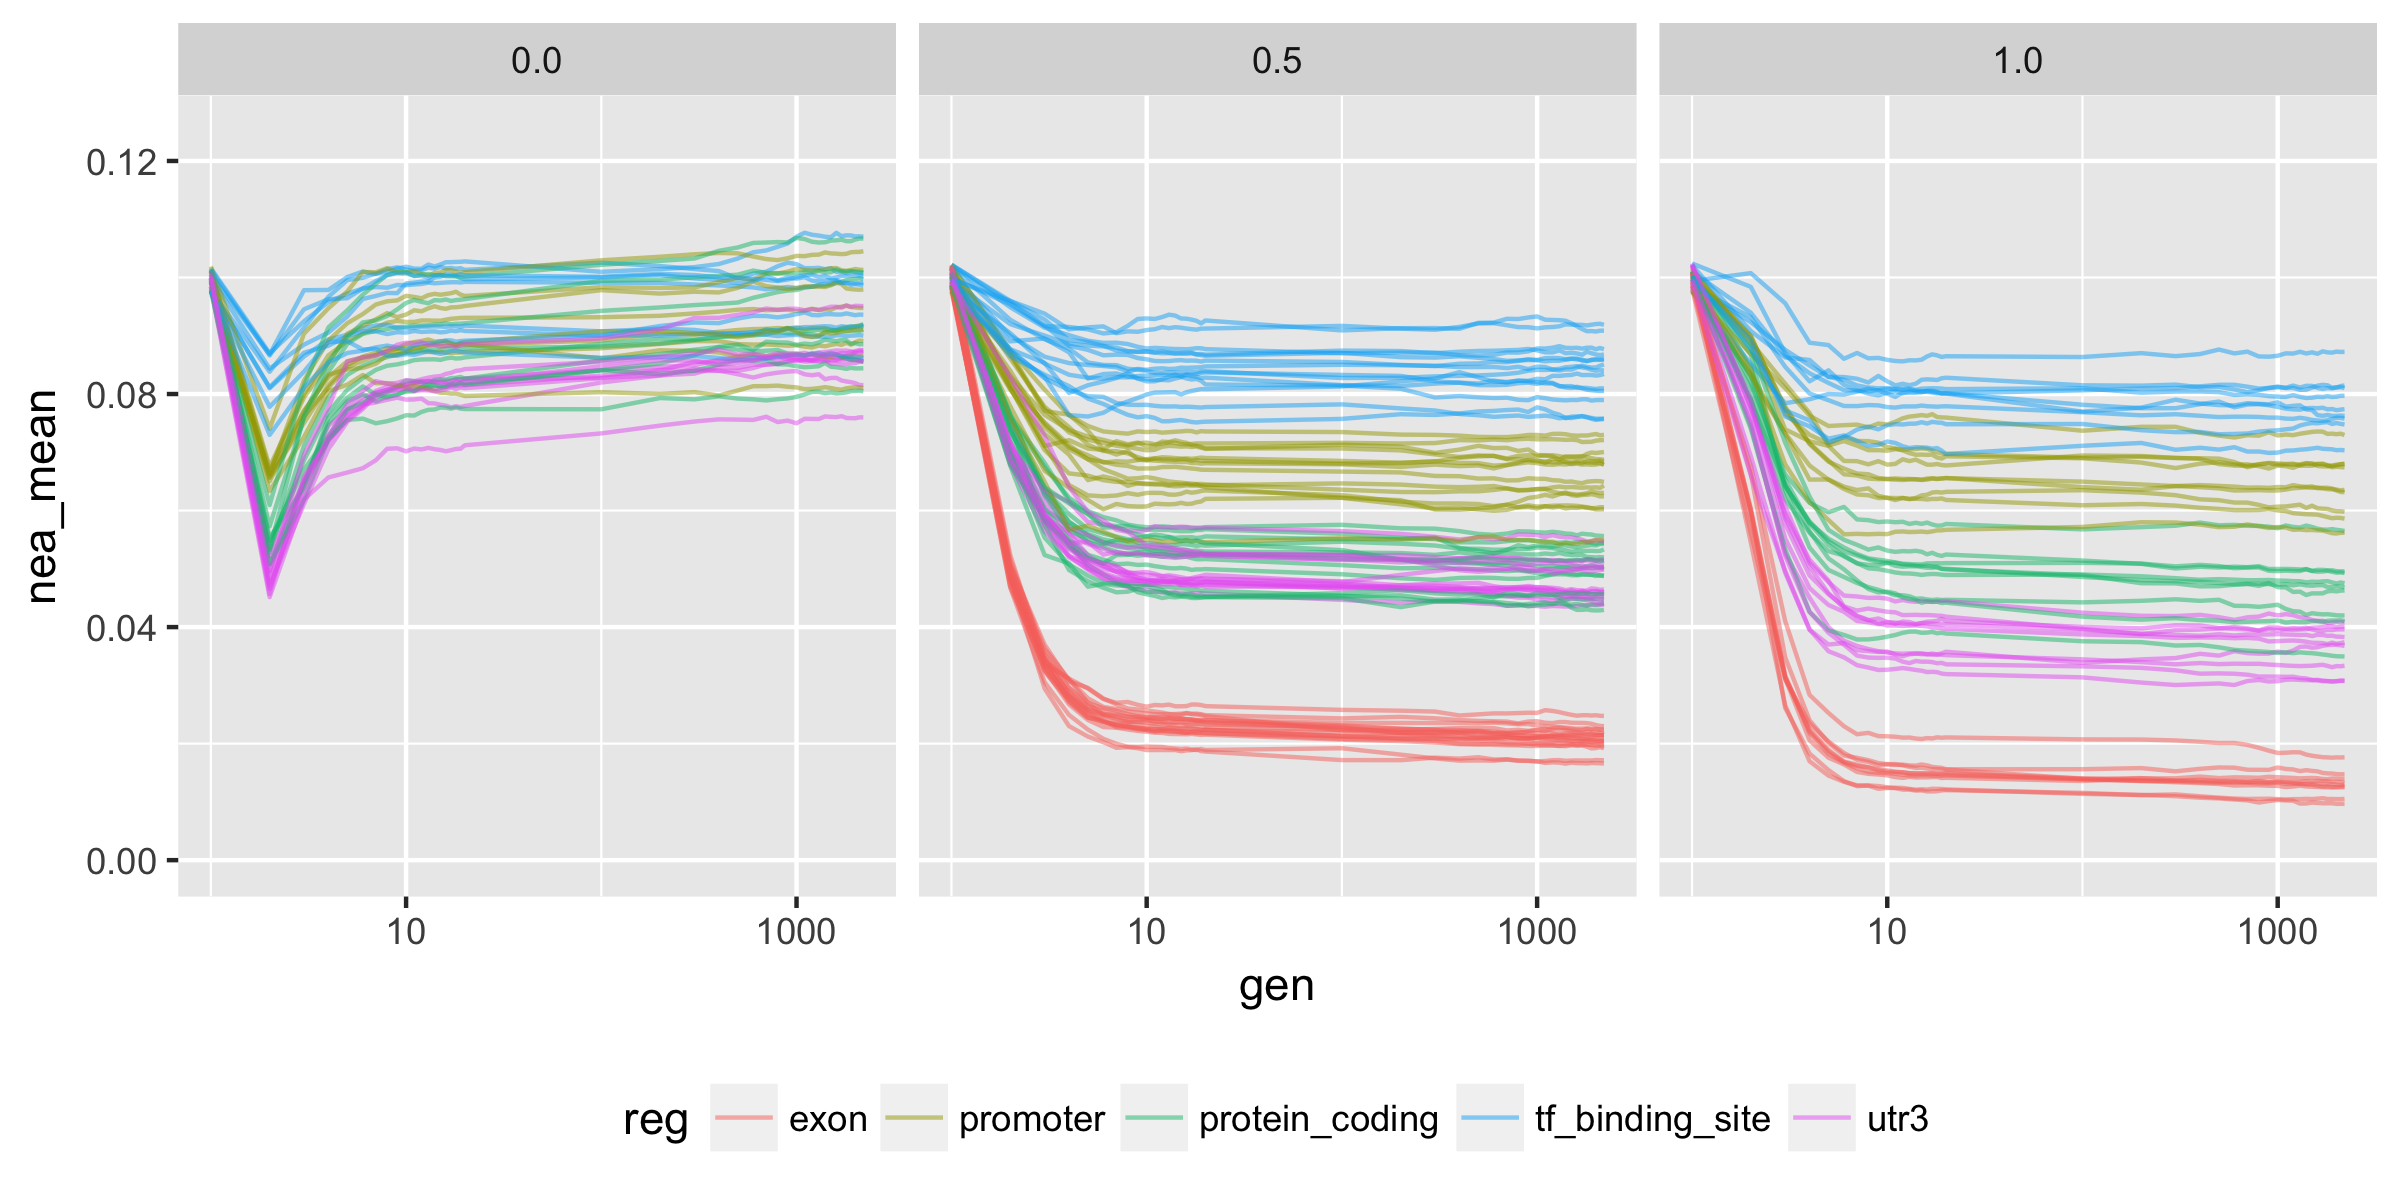

In [9]:
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res=300)

ggplot(df_h, aes(gen, nea_mean, color=reg, group=rep)) + geom_line(alpha=1/2) + facet_grid(. ~ dominance) + coord_cartesian(y=c(0, 0.125)) + theme(legend.position="bottom")
ggplot(df_h, aes(gen, nea_mean, color=reg, group=rep)) + geom_line(alpha=1/2) + facet_grid(. ~ dominance) + coord_cartesian(y=c(0, 0.125)) + scale_x_log10() + theme(legend.position="bottom")

## 2. Desert size vs amount of deleterious sequence (different genomic regions)

In [106]:
regions <- c("exon", "promoter", "protein_coding", "tf_binding_site", "utr3", "neutral_Ne_10000")

### Each represents a summary of one replicate (out of 5 total)

In [107]:
centromeres <- get_centromeres()

In [108]:
desert_sizes <- lapply(1:5, function(rep_i) {

map(regions, function(reg) {
    vcf <- readVcf(paste0("../data/simulations/deserts_", reg, "_h_0.5_rep_", rep_i, "_gen_2200.vcf.gz"))
    r <- ifelse(str_detect(reg, "neutral"), "tf_binding_site", reg)
    markers <- get_markers(vcf, paste0("../data/slim_coords/", r, "_all_sites.bed"), within_region="gap")

    deserts <- get_deserts(markers)
    nogap_deserts <- deserts[-queryHits(findOverlaps(deserts, centromeres))]

    tibble(region=reg,
           size=width(nogap_deserts) / 1e6)
}) %>% bind_rows %>% mutate(rep=rep_i)

}) %>% bind_rows

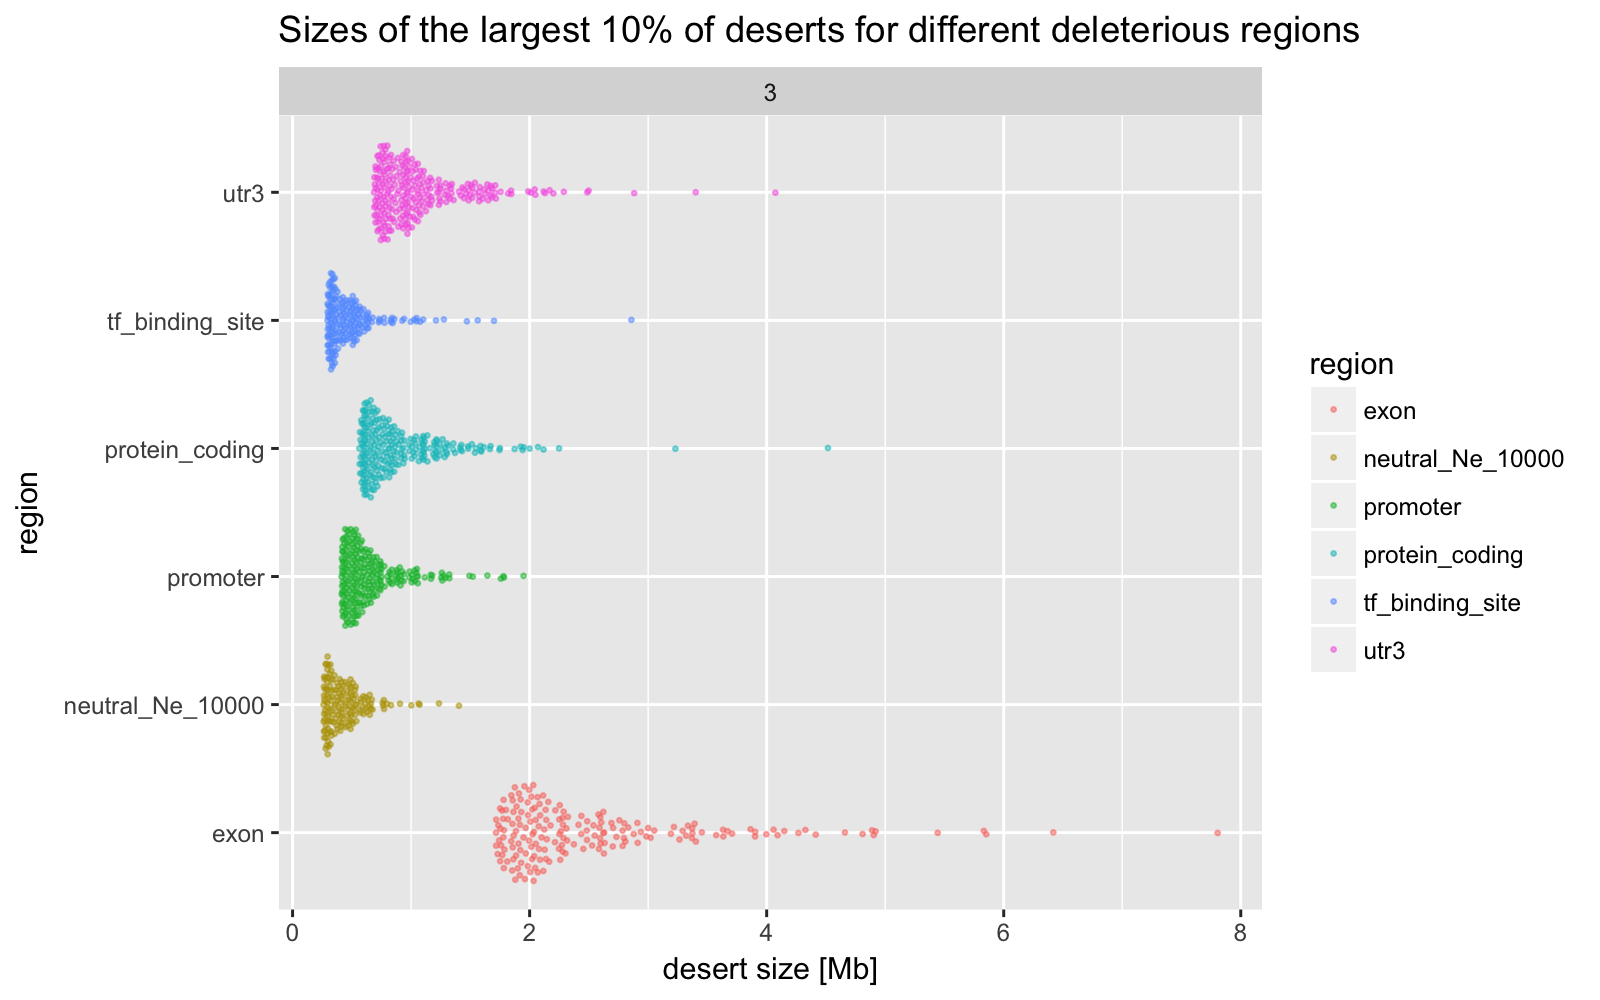

In [109]:
options(repr.plot.width=8, repr.plot.height=5, repr.plot.res=200)

group_by(desert_sizes, region, rep) %>% filter(size > quantile(size, 0.95), rep == 3) %>%
ggplot(aes(region, size, color=region)) + geom_quasirandom(alpha=1/2, size=0.5) +
ggtitle("Sizes of the largest 10% of deserts for different deleterious regions") +
ylab("desert size [Mb]") +
facet_grid(~ rep) +
coord_flip()

### Desert size summary stats for all regions

In [110]:
group_by(desert_sizes, region) %>% summarise(mean(size),
                                             median(size),
                                             min(size),
                                             max(size))

region,mean(size),median(size),min(size),max(size)
exon,0.39184807,0.1426060,1e-06,11.780012
neutral_Ne_10000,0.04911059,0.0000010,1e-06,2.938404
promoter,0.08487899,0.0081760,1e-06,3.830665
protein_coding,0.13242666,0.0298985,1e-06,6.286775
tf_binding_site,0.06272043,0.0000010,1e-06,3.605356
utr3,0.14073064,0.0348250,1e-06,6.433101


In [111]:
lapply(unique(desert_sizes$region), function(r) {
    filter(desert_sizes, region == r, rep == 1) %>%
    arrange(desc(size)) %>%
    head(10)
})

region,size,rep
exon,11.780012,1
exon,6.696565,1
exon,6.562004,1
exon,5.658765,1
exon,5.657765,1
exon,5.165248,1
exon,5.140589,1
exon,5.124701,1
exon,5.086208,1
exon,5.053660,1
